<a href="https://colab.research.google.com/github/xCocco0/alzheimer-recognition/blob/main/alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's Disease AI
The aim of this project is the developing and evaluation of an AI to classify patients affected by various stages of dementia and/or Alzheimer's Disease. We will focus on data inspection and analysis, then proceed on the realization of an AI through the use of machine learning methods.




## The data
All the data were provided by OASIS[[1]](https://www.oasis-brains.org/) (Open Access Series of Imaging Studies), in particular from their third and biggest study OASIS-3.
> _OASIS-3 is a retrospective compilation of data for >1000 participants that were collected across several ongoing projects through the WUSTL Knight ADRC over the course of 30 years. Participants include 609 cognitively normal adults and 489 individuals at various stages of cognitive decline ranging in age from 42-95yrs. All participants were assigned a new random identifier and all dates were removed and normalized to reflect days from entry into study. The dataset contains over 2000 MR sessions which include T1w, T2w, FLAIR, ASL, SWI, time of flight, resting-state BOLD, and DTI sequences. Many of the MR sessions are accompanied by volumetric segmentation files produced through Freesurfer processing. PET imaging from 3 different tracers, PIB, AV45, and FDG, totaling over 1500 raw imaging scans and the accompanying post-processed files from the Pet Unified Pipeline (PUP) are also available in OASIS-3._

Among these information, demographical data and MRI scans reports was of particular relevance.

### Setup up the Python enviroment
This contains imports and constants we will use later.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

index2color = {0:'#64C4E480', 1:'#FFA000A0', 2:'#FF7000A0', 3:'#FF0000A0'}
index2label = {0:'Non demented', 1:'Very mild dementia', 2:'Mild dementia', 3:'Moderate dementia'}
index2cdr = {0:0.0, 1:0.5, 2:1.0, 3:2.0}
cdr2index = {0.0:0, 0.5:1, 1.0:2, 2.0:3}

### Overview
The following were extracted and calculated based on the OASIS-3 Dataset.
- **ID**: Unique dentifier for the patients
- **Sex**: Where 1 stands for male, and 0 for female
- **Age**: Age in years
- **Height**: Measured in mm, has an accurancy of &#177;13mm
- **Weight**: Measured in kg
- **Education**: Total years of education
- **Hand**: Where 1 stands for right handed, 0 for left handed and 2 for ambidextrous
- **mmse**: MMSE[[3]](https://en.wikipedia.org/w/index.php?title=Mini%E2%80%93Mental_State_Examination&oldid=1076211630) (Mini Mental State Examination) score from 0 to 30
- **cdr**: Clinical Dementia Rating, measures the severity of dementia: 0	none, 0.5	very mild, 1	mild, 2	moderate, 3	severe
- **dx1**: Dementia related clinical diagnosis
- **dx2-5**: Other conditions the patient is affected by
- **eTIV**: Estimated Total Intracranical Volume in mm<sup>3</sup>[[2]](https://www.oasis-brains.org/files/OASIS-3_Imaging_Data_Dictionary_v1.5.pdf)
- **brainVol**: Brain valume in mm<sup>3</sup>
- **nWBV**: brainVol/eTIV ratio
- **ventricleVol**: Sum of the volums of left lateral ventricle, right lateral ventricle, 3rd ventricle, 4th ventricle and 5th ventricle in mm<sup>3</sup>
- **ventricleRatio**: ventricleVol/eTIV ratio
- **hcVol**: Total hippocampus volume in mm<sup>3</sup>
- **hcRatio**: hcVol/eTIV ratio

<sub>Note: brain volumes were calculated by OASIS using FreeSurfer[[4]](https://surfer.nmr.mgh.harvard.edu/) software to analyse MRI scans</sub>

In [16]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/oasis3-normalized.csv")
df

,id,sex,age,height,weight,education,hand,mmse,cdr,dx1,...,dx3,dx4,dx5,eTIV,brainVol,nWBV,ventricleVol,ventricleRatio,hcVol,hcRatio
0,OAS30001,0,65,1626,76,12,1,30,0.0,Cognitively normal,...,NaN,NaN,NaN,1196994,750748,0.62719,15583,0.01302,7064,0.00590
1,OAS30002,1,67,1600,71,18,1,29,0.0,Cognitively normal,...,NaN,NaN,NaN,1727246,1042775,0.60372,41460,0.02400,8860,0.00513
2,OAS30003,0,58,1702,73,16,1,30,0.0,Cognitively normal,...,NaN,NaN,NaN,1426999,914549,0.64089,17486,0.01225,8223,0.00576
3,OAS30004,0,55,1626,86,17,0,30,0.0,Cognitively normal,...,NaN,NaN,NaN,1454474,926434,0.63696,22135,0.01522,8286,0.00570
4,OAS30005,0,48,1575,76,16,1,29,0.0,Cognitively normal,...,NaN,NaN,NaN,1539927,990278,0.64307,9869,0.00641,8748,0.00568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,OAS31165,1,55,1753,83,12,1,25,0.0,Cognitively normal,...,NaN,NaN,NaN,1408378,909683,0.64591,11219,0.00797,7744,0.00550
889,OAS31166,0,59,1651,76,13,0,26,0.0,Cognitively normal,...,Active Hypothyroidism,NaN,NaN,1585119,1028191,0.64865,15460,0.00975,8921,0.00563
890,OAS31167,1,51,1778,94,22,1,30,0.0,Cognitively normal,...,NaN,NaN,NaN,1527851,968590,0.63396,12872,0.00842,8867,0.00580
891,OAS31168,1,65,1829,80,16,1,30,0.0,Cognitively normal,...,NaN,NaN,NaN,1621696,958775,0.59122,32998,0.02035,7373,0.00455


Below are a few general statistics about data. Among these, correlation between CDR/MMSE and other features will play a fundamental role in the creation of the AI. This is what we will investigate in the following sections.

In [47]:
print("--- Statistics ---\n",
      df.describe())

print("\n--- Correlation ---\n")
df[["mmse",'cdr','age','weight','height','eTIV','brainVol','nWBV','ventricleVol','ventricleRatio','hcVol','hcRatio']].corr()

--- Statistics ---
               sex         age       height      weight   education  \
count  893.000000  893.000000   893.000000  893.000000  893.000000   
mean     0.456887   68.653975  1675.709966   77.471445   15.614782   
std      0.498417    8.858256    97.005027   17.042696    2.766205   
min      0.000000   42.000000  1295.000000   37.000000    0.000000   
25%      0.000000   64.000000  1600.000000   65.000000   13.000000   
50%      0.000000   69.000000  1676.000000   76.000000   16.000000   
75%      1.000000   74.000000  1753.000000   87.000000   18.000000   
max      1.000000   94.000000  2007.000000  148.000000   24.000000   

             hand        mmse         cdr          eTIV      brainVol  \
count  893.000000  893.000000  893.000000  8.930000e+02  8.930000e+02   
mean     0.931691   27.638298    0.221725  1.505546e+06  8.827183e+05   
std      0.322604    3.579991    0.396309  1.846496e+05  1.082714e+05   
min      0.000000    4.000000    0.000000  1.000078e+06  

,mmse,cdr,age,weight,height,eTIV,brainVol,nWBV,ventricleVol,ventricleRatio,hcVol,hcRatio
mmse,1.000000,-0.795606,-0.291781,0.112163,0.067632,-0.080607,0.218471,0.366115,-0.283967,-0.309052,0.481832,0.459354
cdr,-0.795606,1.000000,0.280224,-0.130354,-0.051822,0.126096,-0.171929,-0.359311,0.325886,0.340021,-0.505890,-0.497787
age,-0.291781,0.280224,1.000000,-0.156481,-0.096301,0.160826,-0.299818,-0.571886,0.466177,0.502588,-0.508876,-0.535751
weight,0.112163,-0.130354,-0.156481,1.000000,0.546525,0.254603,0.320286,0.087500,0.015986,-0.050031,0.237418,0.057149
height,0.067632,-0.051822,-0.096301,0.546525,1.000000,0.507035,0.473230,-0.034870,0.137838,0.022441,0.201406,-0.124105
eTIV,-0.080607,0.126096,0.160826,0.254603,0.507035,1.000000,0.680253,-0.412494,0.569028,0.408275,0.103443,-0.522725
brainVol,0.218471,-0.171929,-0.299818,0.320286,0.473230,0.680253,1.000000,0.377495,0.009516,-0.153958,0.556765,0.063804
nWBV,0.366115,-0.359311,-0.571886,0.087500,-0.034870,-0.412494,0.377495,1.000000,-0.665162,-0.676179,0.548306,0.743378
ventricleVol,-0.283967,0.325886,0.466177,0.015986,0.137838,0.569028,0.009516,-0.665162,1.000000,0.974016,-0.412543,-0.674760
ventricleRatio,-0.309052,0.340021,0.502588,-0.050031,0.022441,0.408275,-0.153958,-0.676179,0.974016,1.000000,-0.498317,-0.660660


### Visualization

#### Distribution plots
The following violin plot will show how the values are distributed in the dataset.

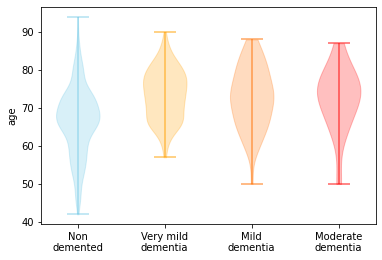

In [20]:
fig, ax = plt.subplots()

index = 0
for i in [0,0.5,1,2]:
  parts = ax.violinplot([
               df[df.cdr == i]['age'].to_numpy(dtype = float),
              ], [index+1])

  parts['bodies'][0].set_color(index2color[index])
  parts['cbars'].set_color(index2color[index])
  parts['cmins'].set_color(index2color[index])
  parts['cmaxes'].set_color(index2color[index])
  parts['bodies'][0].set_alpha(0.25)
  index += 1

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Non\ndemented', 'Very mild\ndementia', 'Mild\ndementia', 'Moderate\ndementia'])
ax.set_ylabel('age')
plt.show()

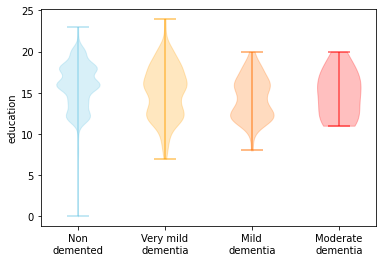

In [18]:
fig, ax = plt.subplots()

index = 0
for i in [0,0.5,1,2]:
  parts = ax.violinplot([
               df[df.cdr == i]['education'].to_numpy(dtype = float),
              ], [index+1])

  parts['bodies'][0].set_color(index2color[index])
  parts['cbars'].set_color(index2color[index])
  parts['cmins'].set_color(index2color[index])
  parts['cmaxes'].set_color(index2color[index])
  parts['bodies'][0].set_alpha(0.25)
  index += 1

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Non\ndemented', 'Very mild\ndementia', 'Mild\ndementia', 'Moderate\ndementia'])
ax.set_ylabel('education')
plt.show()

#### Correlation plots
These are scatter plots that show the relationship between features, for each level of dementia rating (CDR)

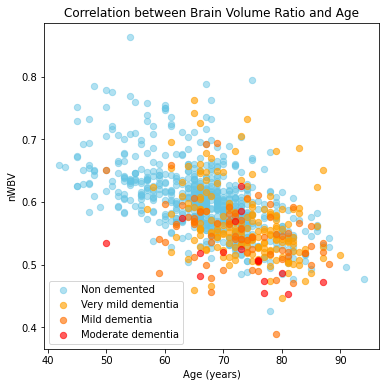

In [28]:
def corr_plot(x,y,title=None,labelx=None,labely=None,dotsize=40):
  if title == None: title = f"Correlation between {x}, {y}"
  if labelx == None: labelx = x
  if labely == None: labely = y;
  fig, ax = plt.subplots(figsize=(6, 6))
  for i in range(0,4):
    ax.scatter(df[df.cdr == index2cdr[i]][x],
              df[df.cdr == index2cdr[i]][y],
              c = index2color[i],
              label = index2label[i], s = dotsize)
  ax.legend()
  ax.set_title(title)
  plt.xlabel(labelx)
  plt.ylabel(labely)
  plt.show()
  
corr_plot('age','nWBV',
          "Correlation between Brain Volume Ratio and Age",'Age (years)','nWBV')

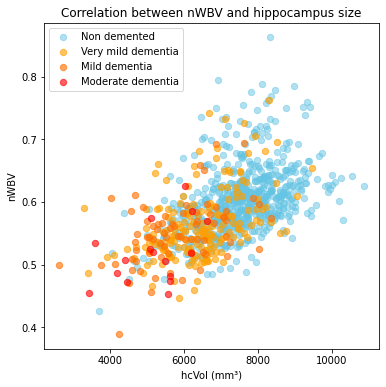

In [30]:
corr_plot('hcVol','nWBV',
          "Correlation between nWBV and hippocampus size",'hcVol (mm\u00B3)','nWBV')

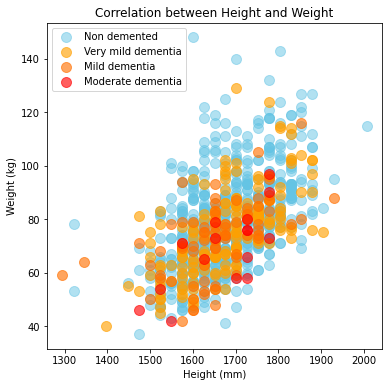

In [31]:
corr_plot('height','weight',
          'Correlation between Height and Weight','Height (mm)','Weight (kg)',100)

From these graphs we can conclude that nWBV and hippocampus size have a strong relationship with dementia, while height doesn't.

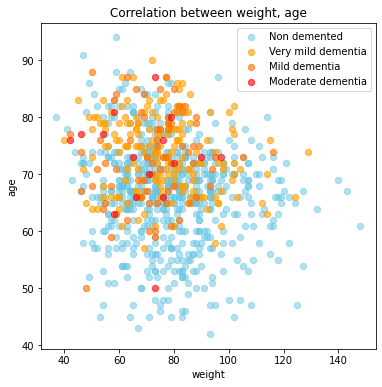

In [32]:
#@title Customise your plot
x = "weight" #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]
y = "age" #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]

corr_plot(x,y)

#### Frequency plots

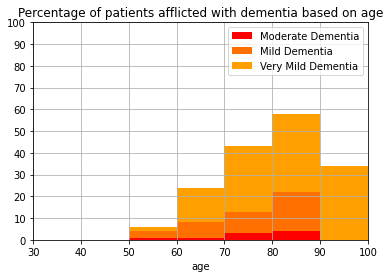

In [33]:
def hist_plot(label, delta, numbars, xmin = 0, xmax = None, df = df):
  if xmax == None:
    xmax = delta*numbars
  hist = np.zeros((numbars,5))
  hist_labels = np.arange(delta/2,delta*(numbars+1/2),delta)

  for index, row in df.iterrows():
    groupindex = int(row[label]/delta)
    if groupindex < numbars:
      hist[groupindex, cdr2index[row["cdr"]]+1] += 1
      hist[groupindex, 0] += 1
  #print(hist)
  for row in hist:
    for i in range(1,5):
      if row[0] == 0:
        row[i] = 0
      else:
        row[i] = np.ceil(100 * row[i] / row[0])
  #print(hist)

  fig, ax = plt.subplots()
  ax.bar(hist_labels, hist[:,4], width = delta, color = "#FF0000", label = "Moderate Dementia")
  ax.bar(hist_labels, hist[:,3], width = delta, bottom = hist[:,4], color = "#FF7000", label = "Mild Dementia")
  ax.bar(hist_labels, hist[:,2], width = delta, bottom = hist[:,4]+hist[:,3], color = "#FFA000", label = "Very Mild Dementia")
  #ax.bar(hist_labels, hist[:,1], width = 10, bottom = hist[:,4]+hist[:,3]+hist[:,2], color = "#64C4E4")

  ax.set_title("Percentage of patients afflicted with dementia based on age")
  ax.set_ylim(0,100)
  ax.set_xlim(xmin,xmax)
  ax.set_xticks(np.arange(xmin,min(xmax,delta*numbars)+delta/2,delta))
  ax.set_yticks(range(0,101,10))
  ax.grid()
  ax.set_xlabel(label)
  ax.legend()
  plt.show()

hist_plot("age", 10, 10, xmin = 30)

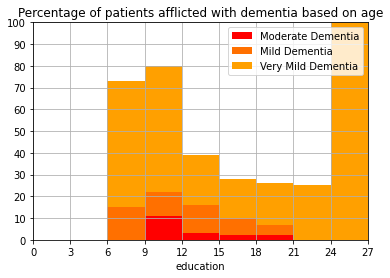

In [34]:
hist_plot("education", 3, 9, xmax = 27)

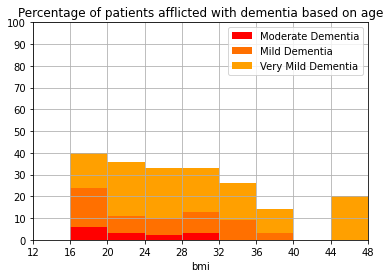

In [35]:
dfbmi = df.loc[:,["height","weight","cdr"]]
dfbmi["bmi"] = (1000000*df["weight"])/(df["height"]**2)

hist_plot("bmi", 4, 20, xmin = 12, xmax = 48, df = dfbmi)

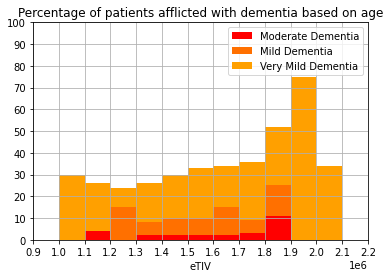

In [36]:
#@title Customise your plot
label = 'eTIV' #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]
delta =  100000#@param {type:"number"}
numbars =  22#@param {type:"integer"}
xmin =  900000#@param {type:"integer"}
xmax = None #@param {type:"raw"}

hist_plot(label, delta, numbars, xmin = xmin, xmax = xmax)

From frequency plot we notice that, as we expected, dementia is more common in older subjects. On the other hand, education years also seemed to be related to dementia. In facts, CDR is often calculated based on MMSE scores and age.

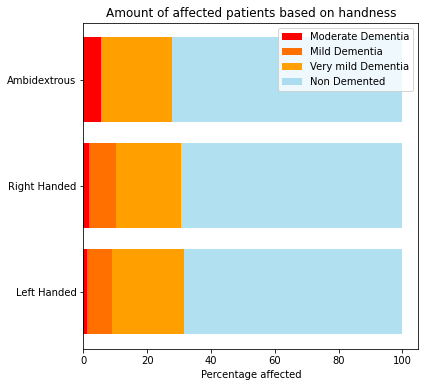

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
bars = np.empty((4,3))

for i in range(0,4):
  for j in range(0,3):
    bars[i,j] = df[(df.hand == j) & (df.cdr == index2cdr[i])].loc[:,"id"].count()
#print(handness)
for i in range(0,3):
  bars[:,i] /= np.sum(bars[:,i])
bars = (bars*100)
#print(bars)
colormap = {0.0:'#64C4E480', 0.5:'#FFA000A0', 1.0:'#FF7000A0', 2.0:'#FF0000A0'}
ax.barh([1,2,3], bars[3,:], color = "#FF0000", label = "Moderate Dementia")
ax.barh([1,2,3], bars[2,:], left = bars[3,:], color = "#FF7000", label = "Mild Dementia")
ax.barh([1,2,3], bars[1,:], left = bars[3,:]+bars[2,:], color = "#FFA000", label = "Very mild Dementia")
ax.barh([1,2,3], bars[0,:], left = bars[3,:]+bars[2,:]+bars[1,:], color = "#64C4E480", label = "Non Demented")
ax.set_yticks([1,2,3])
ax.set_yticklabels(['Left Handed','Right Handed','Ambidextrous'])
ax.set_xlabel("Percentage affected")
ax.set_title("Amount of affected patients based on handness")
ax.legend()
plt.show()

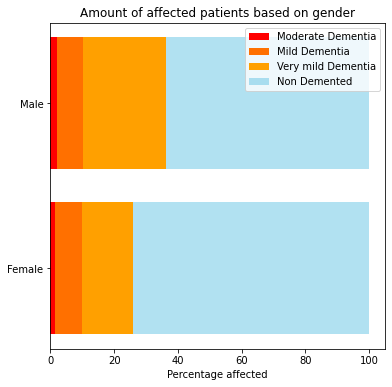

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
bars = np.empty((4,2))

for i in range(0,4):
  for j in range(0,2):
    bars[i,j] = df[(df.sex == j) & (df.cdr == index2cdr[i])].loc[:,"id"].count()
#print(bars)
for i in range(0,2):
  bars[:,i] /= np.sum(bars[:,i])
bars = (bars*100)
#print(bars)
colormap = {0.0:'#64C4E480', 0.5:'#FFA000A0', 1.0:'#FF7000A0', 2.0:'#FF0000A0'}
ax.barh([1,2], bars[3,:], color = "#FF0000", label = "Moderate Dementia")
ax.barh([1,2], bars[2,:], left = bars[3,:], color = "#FF7000", label = "Mild Dementia")
ax.barh([1,2], bars[1,:], left = bars[3,:]+bars[2,:], color = "#FFA000", label = "Very mild Dementia")
ax.barh([1,2], bars[0,:], left = bars[3,:]+bars[2,:]+bars[1,:], color = "#64C4E480", label = "Non Demented")
ax.set_yticks([1,2])
ax.set_yticklabels(['Female','Male'])
ax.set_xlabel("Percentage affected")
ax.set_title("Amount of affected patients based on gender")
ax.legend()
plt.show()

It is remarkable that dementia if more frequent in males, and left handed patients (see [[6]](https://jamanetwork.com/journals/jamaneurology/fullarticle/775393) for more information).

---
## Training

In [ ]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.neighbors
import sklearn.svm
import sklearn.metrics
import sklearn.preprocessing
import sklearn.calibration

#X = df[["age","sex","height","weight","hand","education","nWBV","ventricleRatio","hcRatio"]].to_numpy(dtype = float)
X = df[["age","weight","education","eTIV","brainVol","ventricleVol","hcVol"]].to_numpy(dtype = float)
#X = df[["mmse","education","nWBV"]].to_numpy(dtype = float)
y = np.ravel(df[["cdr"]].to_numpy(dtype = float))

#y = np.where(y > 0, 1, 0)
le = sklearn.preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2, random_state = 4)
#print(X_train, X_test, y_train, y_test)

score_matrix = np.array(
    [[100,  0,  0,  0],
     [ 20,100, 10,  5],
     [ 10, 40,100, 10],
     [  0, 20, 50,100]]
)
print(score_matrix)
def score(y,y_pred):
  n = len(y)
  sc = 0
  for i in range(n):
    sc += score_matrix[y[i],y_pred[i]]
  return sc

myscorer = sklearn.metrics.make_scorer(score)

#print(X_train[:100,:])
clf = sklearn.linear_model.LogisticRegressionCV(
    max_iter = 9999,
    class_weight = {0:1,1:1.5,2:2,3:4},
    scoring = myscorer,
    )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# print(y_pred)
# print(y_test)
print(sklearn.metrics.confusion_matrix(y_test,y_pred))
print("Base score: ", sklearn.metrics.accuracy_score(y_test,y_pred))
print("Adjusted score: ", np.sum(score(y_test,y_pred)/(100*len(y_test))))

In [ ]:
np.set_printoptions(suppress=True)
dx = np.empty(6)
### TODO: AGGIUSTARE QUESTO SCHIFO ###
print("Overstimates")
print("    age ","weight ","education ","eTIV ","brainVol ","ventricleVol ","hcVol ")
for i in range(len(y_pred)):
  if(y_test[i] < y_pred[i]):
    dx = np.ravel(df.loc[:,["mmse","dx1","dx2","dx3","dx4","dx5"]][df.eTIV == X_test[i,3]]
                  .head(1).fillna('').to_numpy(dtype = str))
    print(X_test[i,:])
    print(f"Predicted: {y_test[i]}, was: {y_pred[i]}")
    print("MMSE: ", dx[0], "Diseases: ", ", ".join(dx[1:5]))
    print("----------------------------------------------------------------------------------")

for i in range(len(y_pred)):
  if(y_test[i] > y_pred[i]):
    dx = np.ravel(df.loc[:,["mmse","dx1","dx2","dx3","dx4","dx5"]][df.eTIV == X_test[i,3]]
                  .head(1).fillna('').to_numpy(dtype = str))
    print(X_test[i,:])
    print(f"Predicted: {y_test[i]}, was: {y_pred[i]}")
    print("MMSE: ", dx[0], "Diseases: ", ", ".join(dx[1:5]))
    print("----------------------------------------------------------------------------------")

---
## References
1. OASIS home-page: https://www.oasis-brains.org/
2. OASIS-3 data dictionary: https://www.oasis-brains.org/files/OASIS-3_Imaging_Data_Dictionary_v1.5.pdf
3. *Wikipedia contributors.* (2022, March 9). **Mini–Mental State Examination.** In Wikipedia, The Free Encyclopedia: https://en.wikipedia.org/w/index.php?title=Mini%E2%80%93Mental_State_Examination&oldid=1076211630
4. *Athinoula A. Martinos Center for Biomedical Imaging.* **FreeSurfer sofware**: https://surfer.nmr.mgh.harvard.edu/
5. *Jennifer L. Whitwell, William R. Crum, Hilary C. Watt and Nick C. Fox.* **Normalization of Cerebral Volumes by Use of Intracranial Volume**: Implications for Longitudinal Quantitative MR Imaging: http://www.ajnr.org/content/22/8/1483
6. *Doody RS, Vacca JL, Massman PJ, Liao T.* **The Influence of Handedness on the Clinical Presentation and Neuropsychology of Alzheimer Disease**. Arch Neurol. 1999;56(9):1133–1137. doi:10.1001/archneur.56.9.1133: https://jamanetwork.com/journals/jamaneurology/fullarticle/775393
7. *Keith A. Johnson, Nick C. Fox, Reisa A. Sperling and William E. Klunk.* **Brain Imaging in Alzheimer Disease**: http://perspectivesinmedicine.cshlp.org/content/2/4/a006213.long
8. *Apostolova LG.* **Alzheimer Disease. Continuum (Minneap Minn).** 2016;22(2 Dementia):419-434. doi:10.1212/CON.0000000000000307: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5390933/
9. *Ridha, B.H., Anderson, V.M., Barnes, J. et al.* **Volumetric MRI and cognitive measures in Alzheimer disease**. J Neurol 255, 567–574 (2008): https://doi.org/10.1007/s00415-008-0750-9

